# 1. Problem Statement
- Predict the base fare amount of yellow taxis in NY City given the following features:
    - trip_duration_minutes	
    - trip_distance
    - trip_speed

The target column is a continuous numerical variable (fare_amount), hence the problem we're trying to solve is a **regression problem.**

# 2. Business Objectives and Constraints
**Objective:** Predict base fare amount as accurately as possible.

**Constraints:**
- Latency.
- Interpretability is not very important.
- Finding relative error (percentage error) is important.

# 3. Data
- Data is taken from this URL: https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page
- Data for only 'Yellow Taxi' will be considered for time period "January-April 2022".
- Data is in parquet format

# 3.1. Features in the data

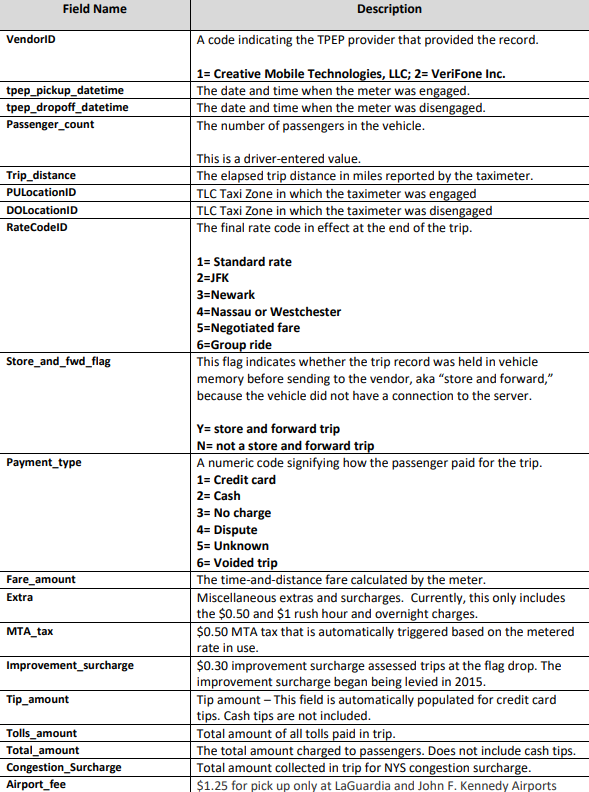

# 4. Performance Metrics
- Mean Absolute Percentage Error (MAPE) - Primary KPI
    - We don't want to just use the differences in prediction. We want to be able to see the % difference, hence MAPE is the primary KPI 
    
- Mean Squared Error (MSE)

# 5. Read (all) Parquet Files

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [2]:
import os 

# read all parquet data files
df = pd.concat((pd.read_parquet(f'Data/Imports/{data_file}', engine='pyarrow').astype({
    'passenger_count':'float32',
    'trip_distance':'float32',
    'fare_amount':'float32',
    'extra':'float16',
    'mta_tax':'float16',
    'tip_amount':'float16',
    'tolls_amount':'float16',
    'improvement_surcharge':'float16',
    'total_amount': 'float32',
    'congestion_surcharge':'float16',
    'airport_fee':'float16'
}) for data_file in os.listdir('Data/Imports') if data_file.endswith('parquet')), ignore_index=True) 

# keep data for 2022 only
df = df.loc[(df['tpep_pickup_datetime'].dt.year == 2022) & (df['tpep_dropoff_datetime'].dt.year == 2022)]

# keep data for from jan-march of 2022 only
df = df.loc[df['tpep_pickup_datetime'].dt.month.isin([1, 2, 3, 4]) & df['tpep_dropoff_datetime'].dt.month.isin([1, 2, 3, 4])]

# randomly sample 3 million points
df = df.sample(3000000, random_state=10)

# store og data shape
og_data_shape = df.shape[0]

# top 5 rows
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
11730984,2,2022-04-23 22:14:51,2022-04-23 22:28:51,6.0,2.30,1.0,N,141,238,1,11.0,0.5,0.5,2.960938,0.0,0.300049,17.760000,2.5,0.0
3542835,1,2022-02-11 21:26:50,2022-02-11 21:42:35,1.0,3.50,1.0,N,90,87,1,12.5,3.0,0.5,4.101562,0.0,0.300049,20.400000,2.5,0.0
9296422,2,2022-04-02 19:55:00,2022-04-02 20:04:25,2.0,1.23,1.0,N,230,142,1,7.5,0.0,0.5,3.240234,0.0,0.300049,14.040000,2.5,0.0
9447245,2,2022-04-04 10:11:27,2022-04-04 10:24:57,2.0,1.88,1.0,N,170,237,1,10.5,0.0,0.5,2.759766,0.0,0.300049,16.559999,2.5,0.0
9032403,1,2022-03-21 10:06:10,2022-03-21 10:16:44,NaN,2.90,NaN,None,229,224,0,11.5,0.0,0.5,2.220703,0.0,0.300049,17.020000,NaN,NaN


In [3]:
# read taxi zone lookup table
# Info about New York Boroughs - https://en.wikipedia.org/wiki/Boroughs_of_New_York_City

taxi_zone_lookup = pd.read_csv('Data/Imports/taxi_zone_lookup_table.csv').dropna()
taxi_zone_lookup.head()

,LocationID,Borough,Zone,service_zone
0,1,EWR,Newark Airport,EWR
1,2,Queens,Jamaica Bay,Boro Zone
2,3,Bronx,Allerton/Pelham Gardens,Boro Zone
3,4,Manhattan,Alphabet City,Yellow Zone
4,5,Staten Island,Arden Heights,Boro Zone


In [4]:
# keep only those pick-up location id's which are in read taxi zone lookup table
df = df.loc[df['PULocationID'].isin(taxi_zone_lookup['LocationID'])]

# keep only those drop-off location id's which are in read taxi zone lookup table
df = df.loc[df['DOLocationID'].isin(taxi_zone_lookup['LocationID'])]

# store shape after removing pu and do points outside ny 
shape_after_removing_pu_do_outside_ny = df.shape[0]

In [5]:
# add borough, zone and service zone columns for pickups
df = df.merge(taxi_zone_lookup.rename(columns={
    'LocationID':'PULocationID',
    'Borough':'pu_borough',
    'Zone':'pu_zone',
    'service_zone':'pu_service_zone'
}), on='PULocationID', how='left')

df[['PULocationID', 'pu_borough', 'pu_zone', 'pu_service_zone']].head()

,PULocationID,pu_borough,pu_zone,pu_service_zone
0,141,Manhattan,Lenox Hill West,Yellow Zone
1,90,Manhattan,Flatiron,Yellow Zone
2,230,Manhattan,Times Sq/Theatre District,Yellow Zone
3,170,Manhattan,Murray Hill,Yellow Zone
4,229,Manhattan,Sutton Place/Turtle Bay North,Yellow Zone


In [6]:
# add borough, zone and service zone columns for drop-offs
df = df.merge(taxi_zone_lookup.rename(columns={
    'LocationID':'DOLocationID',
    'Borough':'do_borough',
    'Zone':'do_zone',
    'service_zone':'do_service_zone'
}), on='DOLocationID', how='left')

df[['DOLocationID', 'do_borough', 'do_zone', 'do_service_zone']].head()

,DOLocationID,do_borough,do_zone,do_service_zone
0,238,Manhattan,Upper West Side North,Yellow Zone
1,87,Manhattan,Financial District North,Yellow Zone
2,142,Manhattan,Lincoln Square East,Yellow Zone
3,237,Manhattan,Upper East Side South,Yellow Zone
4,224,Manhattan,Stuy Town/Peter Cooper Village,Yellow Zone


In [7]:
df = df.rename(columns={
    'VendorID':'vendor_id',
    'RatecodeID':'rate_code_id',
    'PULocationID':'pu_location_id', 
    'DOLocationID':'do_location_id'
})

# pickups and drop-offs
df[['pu_location_id', 'do_location_id', 'pu_borough', 'do_borough', 'pu_zone', 'do_zone']]

,pu_location_id,do_location_id,pu_borough,do_borough,pu_zone,do_zone
0,141,238,Manhattan,Manhattan,Lenox Hill West,Upper West Side North
1,90,87,Manhattan,Manhattan,Flatiron,Financial District North
2,230,142,Manhattan,Manhattan,Times Sq/Theatre District,Lincoln Square East
3,170,237,Manhattan,Manhattan,Murray Hill,Upper East Side South
4,229,224,Manhattan,Manhattan,Sutton Place/Turtle Bay North,Stuy Town/Peter Cooper Village
...,...,...,...,...,...,...
2947038,138,121,Queens,Queens,LaGuardia Airport,Hillcrest/Pomonok
2947039,263,143,Manhattan,Manhattan,Yorkville West,Lincoln Square West
2947040,262,239,Manhattan,Manhattan,Yorkville East,Upper West Side South
2947041,237,162,Manhattan,Manhattan,Upper East Side South,Midtown East


In [8]:
columns = ['vendor_id', 'tpep_pickup_datetime', 'tpep_dropoff_datetime', 'passenger_count', 'trip_distance', 'rate_code_id',
           'store_and_fwd_flag', 'pu_location_id', 'pu_borough', 'pu_zone', 'pu_service_zone', 'do_location_id', 'do_borough', 
           'do_zone', 'do_service_zone', 'payment_type', 'fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount', 
           'improvement_surcharge', 'total_amount', 'congestion_surcharge', 'airport_fee']

df = df[columns]

df.head()

,vendor_id,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,rate_code_id,store_and_fwd_flag,pu_location_id,pu_borough,pu_zone,...,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,2,2022-04-23 22:14:51,2022-04-23 22:28:51,6.0,2.30,1.0,N,141,Manhattan,Lenox Hill West,...,1,11.0,0.5,0.5,2.960938,0.0,0.300049,17.760000,2.5,0.0
1,1,2022-02-11 21:26:50,2022-02-11 21:42:35,1.0,3.50,1.0,N,90,Manhattan,Flatiron,...,1,12.5,3.0,0.5,4.101562,0.0,0.300049,20.400000,2.5,0.0
2,2,2022-04-02 19:55:00,2022-04-02 20:04:25,2.0,1.23,1.0,N,230,Manhattan,Times Sq/Theatre District,...,1,7.5,0.0,0.5,3.240234,0.0,0.300049,14.040000,2.5,0.0
3,2,2022-04-04 10:11:27,2022-04-04 10:24:57,2.0,1.88,1.0,N,170,Manhattan,Murray Hill,...,1,10.5,0.0,0.5,2.759766,0.0,0.300049,16.559999,2.5,0.0
4,1,2022-03-21 10:06:10,2022-03-21 10:16:44,NaN,2.90,NaN,None,229,Manhattan,Sutton Place/Turtle Bay North,...,0,11.5,0.0,0.5,2.220703,0.0,0.300049,17.020000,NaN,NaN


In [9]:
df['pu_borough'].value_counts()

Manhattan        2697535
Queens            224524
Brooklyn           20401
Bronx               3922
EWR                  463
Staten Island        198
Name: pu_borough, dtype: int64

In [10]:
df['do_borough'].value_counts()

Manhattan        2669299
Queens            142390
Brooklyn          110189
Bronx              18206
EWR                 6239
Staten Island        720
Name: do_borough, dtype: int64

In [11]:
# set appropriate category
df = df.astype({
    'pu_borough':'category', 
    'do_borough':'category', 
    'pu_zone':'category', 
    'do_zone':'category', 
    'pu_service_zone':'category', 
    'do_service_zone':'category'
})

df = df.reset_index(drop=True)
df.head()

,vendor_id,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,rate_code_id,store_and_fwd_flag,pu_location_id,pu_borough,pu_zone,...,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,2,2022-04-23 22:14:51,2022-04-23 22:28:51,6.0,2.30,1.0,N,141,Manhattan,Lenox Hill West,...,1,11.0,0.5,0.5,2.960938,0.0,0.300049,17.760000,2.5,0.0
1,1,2022-02-11 21:26:50,2022-02-11 21:42:35,1.0,3.50,1.0,N,90,Manhattan,Flatiron,...,1,12.5,3.0,0.5,4.101562,0.0,0.300049,20.400000,2.5,0.0
2,2,2022-04-02 19:55:00,2022-04-02 20:04:25,2.0,1.23,1.0,N,230,Manhattan,Times Sq/Theatre District,...,1,7.5,0.0,0.5,3.240234,0.0,0.300049,14.040000,2.5,0.0
3,2,2022-04-04 10:11:27,2022-04-04 10:24:57,2.0,1.88,1.0,N,170,Manhattan,Murray Hill,...,1,10.5,0.0,0.5,2.759766,0.0,0.300049,16.559999,2.5,0.0
4,1,2022-03-21 10:06:10,2022-03-21 10:16:44,NaN,2.90,NaN,None,229,Manhattan,Sutton Place/Turtle Bay North,...,0,11.5,0.0,0.5,2.220703,0.0,0.300049,17.020000,NaN,NaN


# 7. Creating New feature, Univariate Analysis & Removing Outliers
## 7.1. Creating new feature - Trip duration (in minutes)
- Calculated by the following subtraction operation:
    - (tpep_dropoff_datetime - tpep_pickup_datetime)

#### According to NYC Taxi & Limousine Commision Regulations, the maximum allowed trip duration in a 24 hour period is 10 hours
Reference link: https://www1.nyc.gov/site/tlc/about/fatigued-driving-prevention-frequently-asked-questions.page#:~:text=The%20rule%20applies%20to%20taxi,week%20(Monday%2DSunday).

In [12]:
# function for computing percentiles

# get percentiles from 0-100
def get_percentile_0_100(df, column):
    for percentile in range(0, 110, 10):
        percentile_value = df[column].quantile(percentile/100)
        print(f'{percentile}th percentile value is {percentile_value}')

# get percentiles from 90-100
def get_percentile_90_100(df, column):
    for percentile in range(90, 101):
        percentile_value = df[column].quantile(percentile/100)
        print(f'{percentile}th percentile value is {percentile_value}')

# get percentiles from 99-100
def get_percentile_99_100(df, column):
    for percentile in np.arange(99.0, 100.1, 0.10):
        percentile_value = df[column].quantile(np.round(percentile, 1)/100)
        print(f'{np.round(percentile, 1)}th percentile value is {percentile_value}')

In [13]:
# calculate trip duration
df['trip_duration'] = df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime']

df['trip_duration'].head()

0   0 days 00:14:00
1   0 days 00:15:45
2   0 days 00:09:25
3   0 days 00:13:30
4   0 days 00:10:34
Name: trip_duration, dtype: timedelta64[ns]

In [14]:
# calculate trip duration in minutes
df['trip_duration_minutes'] = df['trip_duration'].astype('timedelta64[m]')
df['trip_duration_minutes'].head()

0    14.0
1    15.0
2     9.0
3    13.0
4    10.0
Name: trip_duration_minutes, dtype: float64

In [15]:
# check if trip_duration_minutes has -ve values
df.loc[df['trip_duration_minutes'].lt(0)]

,vendor_id,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,rate_code_id,store_and_fwd_flag,pu_location_id,pu_borough,pu_zone,...,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,trip_duration,trip_duration_minutes


### 7.1.1. Univariate Analysis - Trip Duration (Minutes)

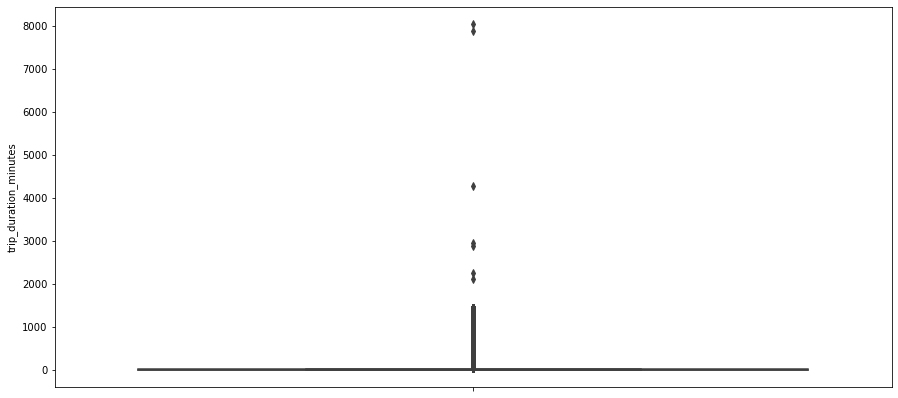

In [16]:
plt.figure(figsize=(15, 7))
sns.boxplot(y='trip_duration_minutes', data=df);

### Observation:
- Box-plot shows **presence of outliers** and non-interpretable
- 1000 minutes mean a trip duration of ~16 hours.
- 1400 minutes mean a trip duration of ~24 hours.

In [17]:
# get percentile values between 0-100
get_percentile_0_100(df, 'trip_duration_minutes')

0th percentile value is 0.0
10th percentile value is 4.0
20th percentile value is 6.0
30th percentile value is 7.0
40th percentile value is 9.0
50th percentile value is 11.0
60th percentile value is 13.0
70th percentile value is 16.0
80th percentile value is 20.0
90th percentile value is 27.0
100th percentile value is 8037.0


In [18]:
# get percentile values between 90-100
get_percentile_90_100(df, 'trip_duration_minutes')

90th percentile value is 27.0
91th percentile value is 28.0
92th percentile value is 30.0
93th percentile value is 31.0
94th percentile value is 33.0
95th percentile value is 36.0
96th percentile value is 39.0
97th percentile value is 43.0
98th percentile value is 49.0
99th percentile value is 59.0
100th percentile value is 8037.0


### Observation:
- 99th percentile value is reasonable
- 100th percentile value is absurd 

Let's zoom in between 99th and 100th Percentile values 

In [19]:
# get percentile values between 99-100
get_percentile_99_100(df, 'trip_duration_minutes')

99.0th percentile value is 59.0
99.1th percentile value is 61.0
99.2th percentile value is 62.0
99.3th percentile value is 64.0
99.4th percentile value is 67.0
99.5th percentile value is 70.0
99.6th percentile value is 74.0
99.7th percentile value is 79.0
99.8th percentile value is 88.0
99.9th percentile value is 1325.8320000004023
100.0th percentile value is 8037.0


In [20]:
# As mentioned above: 
# According to NYC Taxi & Limousine Commision Regulations, the maximum allowed trip duration in a 24 hour period is 10 hours
# keep trips where trip_duration_minutes >=1 minute and <600 hours

df = df.loc[(df['trip_duration_minutes'] >= 1) & (df['trip_duration_minutes'] <= 600)]

# store data shape after removing points trip duration >600 
shape_after_removing_trip_duration_outlier = df.shape[0]

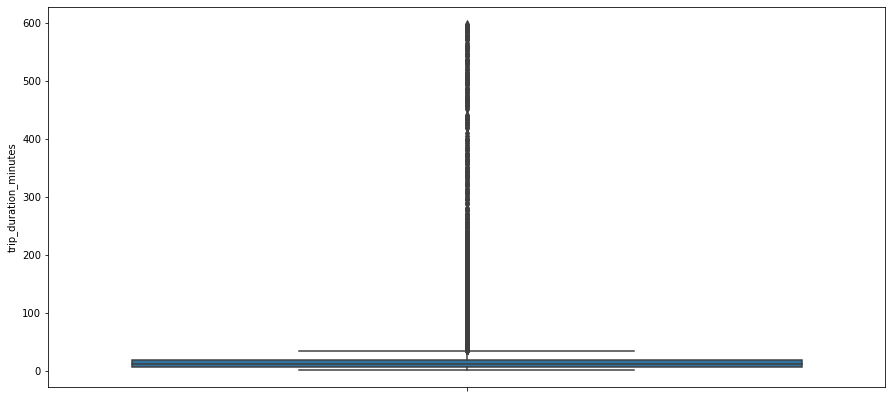

In [21]:
# box-plot after removal of outliers
plt.figure(figsize=(15, 7))
sns.boxplot(y='trip_duration_minutes', data=df);

### Observation:
- Box-plot after removing outliers is still **not interpretable.**

In [22]:
# get percentile values after removing outliers
get_percentile_0_100(df, 'trip_duration_minutes')

0th percentile value is 1.0
10th percentile value is 4.0
20th percentile value is 6.0
30th percentile value is 7.0
40th percentile value is 9.0
50th percentile value is 11.0
60th percentile value is 13.0
70th percentile value is 16.0
80th percentile value is 20.0
90th percentile value is 27.0
100th percentile value is 598.0


<Figure size 1080x504 with 0 Axes>

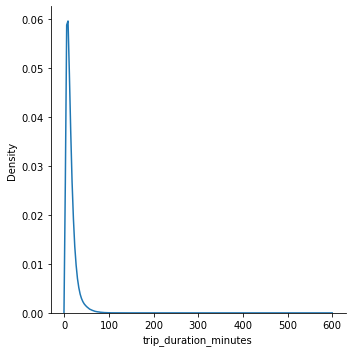

In [23]:
# plot PDF
plt.figure(figsize=(15, 7))
sns.displot(data=df, x='trip_duration_minutes', kind="kde");

### Observation:
- PDF has positive skew.

## 7.2. Creating new feature - Trip Speed
- distance is in miles, duration in minutes
- Trip speed will be calculated using speed = distance/time
- Result will be in miles/hour

In [24]:
# supress warning
pd.options.mode.chained_assignment = None  # default='warn'

df['trip_speed'] = 60*df['trip_distance']/df['trip_duration_minutes']

# get percentile between 0-100 values for trip speed
get_percentile_0_100(df, 'trip_speed')

0th percentile value is 0.0
10th percentile value is 6.654545870694247
20th percentile value is 8.0
30th percentile value is 9.0
40th percentile value is 10.0363637750799
50th percentile value is 11.142857142857142
60th percentile value is 12.359999847412109
70th percentile value is 14.0
80th percentile value is 16.5
90th percentile value is 21.385713849748885
100th percentile value is 6479684.5


In [25]:
# get percentile between 90-100 values for trip speed
get_percentile_90_100(df, 'trip_speed')

90th percentile value is 21.385713849748885
91th percentile value is 22.2000004695012
92th percentile value is 23.142857142857142
93th percentile value is 24.097676121911338
94th percentile value is 25.384615384615383
95th percentile value is 26.849998474121094
96th percentile value is 28.52307598407452
97th percentile value is 30.599998474121094
98th percentile value is 33.366668701171875
99th percentile value is 37.41818210671165
100th percentile value is 6479684.5


In [26]:
# get percentile between 99-100 values for trip speed
get_percentile_99_100(df, 'trip_speed')

99.0th percentile value is 37.41818210671165
99.1th percentile value is 37.980000813802086
99.2th percentile value is 38.58620689655172
99.3th percentile value is 39.244443540219905
99.4th percentile value is 40.0
99.5th percentile value is 40.80000187800481
99.6th percentile value is 41.8
99.7th percentile value is 42.8999989827474
99.8th percentile value is 44.48127945963525
99.9th percentile value is 47.18181818181818
100.0th percentile value is 6479684.5


In [27]:
# keep trips where trip_speed >0 and <48 hours based on 99.9 percentile value
df = df.loc[(df['trip_speed'] > 0) & (df['trip_speed'] <= 47)]

# store data shape after removing points where trip speed >47 
shape_after_removing_trip_speed_outlier = df.shape[0]

## 7.3. Working with 'Trip Distance' Feature

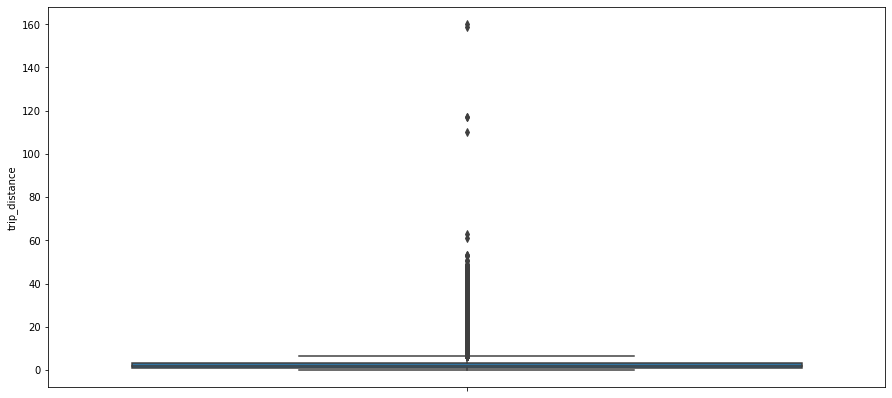

In [28]:
# box-plot of trip distance
plt.figure(figsize=(15, 7))
sns.boxplot(y='trip_distance', data=df);

### Observation:
- 100 to 120 miles is a lot of distance for a yellow cab to go.
- They can be flagged as outliers
- **Boxplot of trip_distance is non-interpretable**

In [29]:
# get percentile between 0-100 values for trip distance
get_percentile_0_100(df, 'trip_distance')

0th percentile value is 0.009999999776482582
10th percentile value is 0.7200000286102295
20th percentile value is 1.0
30th percentile value is 1.2400000095367432
40th percentile value is 1.5
50th percentile value is 1.8300000429153442
60th percentile value is 2.25
70th percentile value is 2.859999895095825
80th percentile value is 3.9600000381469727
90th percentile value is 7.579999923706055
100th percentile value is 160.02000427246094


In [30]:
# get percentile between 90-100 values for trip distance
get_percentile_90_100(df, 'trip_distance')

90th percentile value is 7.579999923706055
91th percentile value is 8.34000015258789
92th percentile value is 9.100000381469727
93th percentile value is 9.850000381469727
94th percentile value is 10.739999771118164
95th percentile value is 12.0
96th percentile value is 15.069999694824219
97th percentile value is 17.260000228881836
98th percentile value is 18.200000762939453
99th percentile value is 19.5
100th percentile value is 160.02000427246094


In [31]:
# get percentile between 99-100 values for trip distance
get_percentile_99_100(df, 'trip_distance')

99.0th percentile value is 19.5
99.1th percentile value is 19.700000762939453
99.2th percentile value is 19.940000534057617
99.3th percentile value is 20.200000762939453
99.4th percentile value is 20.5
99.5th percentile value is 20.799999237060547
99.6th percentile value is 21.15959983825646
99.7th percentile value is 21.610000610351562
99.8th percentile value is 22.3700008392334
99.9th percentile value is 24.737399711611122
100.0th percentile value is 160.02000427246094


In [32]:
# keep trips where trip_distance >0 and <= 25 miles (round off is okay) based on 99.9th percentile value
df = df.loc[(df['trip_distance'] > 0) & (df['trip_distance'] <= 25)]

# store data shape after removing points where trip distance >25 
shape_after_removing_trip_distance_outlier = df.shape[0]

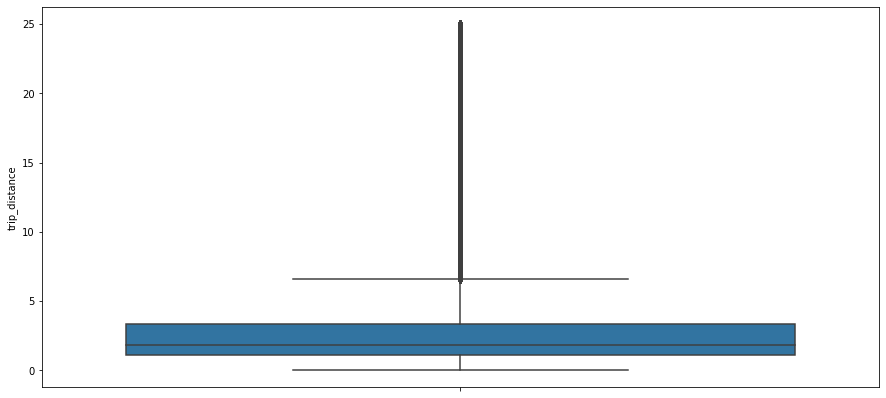

In [33]:
# box-plot of trip distance after removing outliers
plt.figure(figsize=(15, 7))
sns.boxplot(y='trip_distance', data=df);

## 7.4. Working with 'Total Amount' Feature

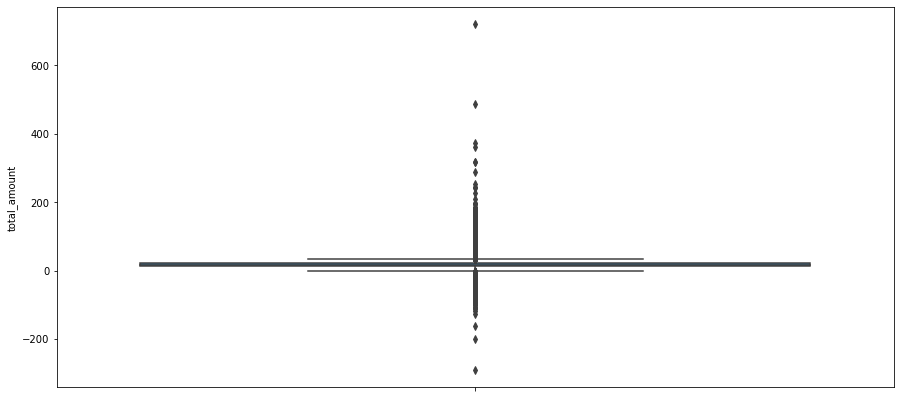

In [34]:
# box-plot of total amount
plt.figure(figsize=(15, 7))
sns.boxplot(y='total_amount', data=df);

### Observation:
- There is one total amount value slightly less than ~$200k which is huge.
- **Boxplot of trip_amount is non-interpretable**

In [35]:
# get percentile between 0-100 values for total amount
get_percentile_0_100(df, 'total_amount')

0th percentile value is -290.79998779296875
10th percentile value is 9.800000190734863
20th percentile value is 11.270000457763672
30th percentile value is 12.359999656677246
40th percentile value is 13.800000190734863
50th percentile value is 15.300000190734863
60th percentile value is 17.149999618530273
70th percentile value is 19.350000381469727
80th percentile value is 23.34000015258789
90th percentile value is 34.61000061035156
100th percentile value is 720.3499755859375


In [36]:
# get percentile between 90-100 values for total amount
get_percentile_90_100(df, 'total_amount')

90th percentile value is 34.61000061035156
91th percentile value is 37.54999923706055
92th percentile value is 40.86000061035156
93th percentile value is 44.29999923706055
94th percentile value is 48.060001373291016
95th percentile value is 52.54999923706055
96th percentile value is 58.54999923706055
97th percentile value is 64.66999816894531
98th percentile value is 71.8499984741211
99th percentile value is 75.72000122070312
100th percentile value is 720.3499755859375


In [37]:
# get percentile between 99-100 values for total amount
get_percentile_99_100(df, 'total_amount')

99.0th percentile value is 75.72000122070312
99.1th percentile value is 75.72000122070312
99.2th percentile value is 76.98631988525142
99.3th percentile value is 78.0999984741211
99.4th percentile value is 78.87999725341797
99.5th percentile value is 80.0999984741211
99.6th percentile value is 81.0999984741211
99.7th percentile value is 82.3499984741211
99.8th percentile value is 87.05000305175781
99.9th percentile value is 98.05000305175781
100.0th percentile value is 720.3499755859375


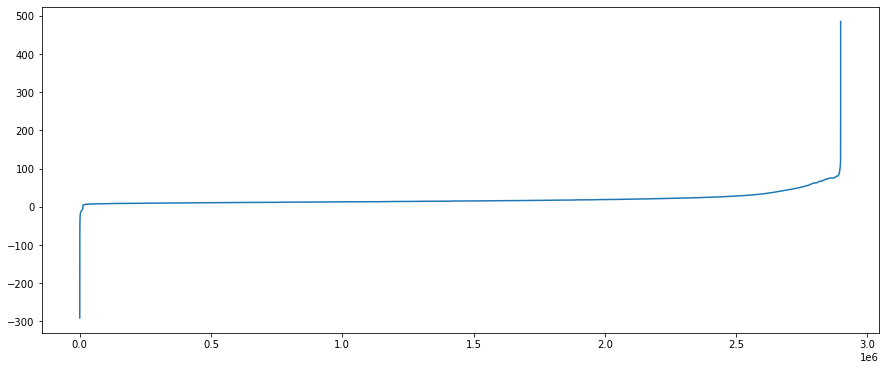

In [38]:
# plot sorted total_amount
sorted_total_amount = df['total_amount'].sort_values().reset_index(drop=True)
plt.figure(figsize=(15, 6))
plt.plot(sorted_total_amount.iloc[0:-1]);

### Observation:
- A very sharp increase can be seen toward the end.

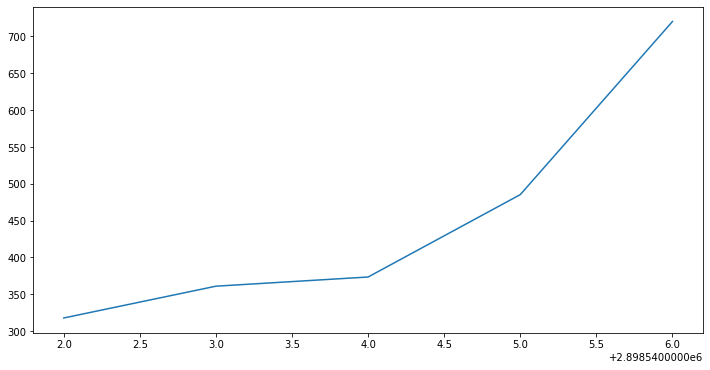

In [39]:
# plot only last 5 points
plt.figure(figsize=(12, 6))
plt.plot(sorted_total_amount.iloc[-5:]);

In [40]:
sorted_total_amount.iloc[-5:]

2898542    317.799988
2898543    360.959991
2898544    373.420013
2898545    485.299988
2898546    720.349976
Name: total_amount, dtype: float32

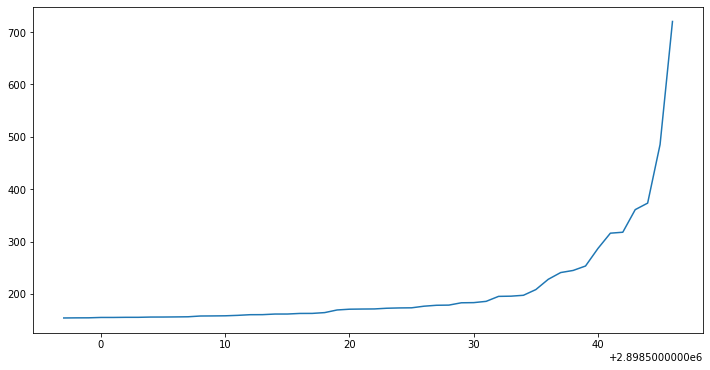

In [41]:
# plot only last 50 points upto 2nd last
plt.figure(figsize=(12, 6))
plt.plot(sorted_total_amount.iloc[-50:]);

### Observation:
- The plot resembles an elbow.
- Using "elbow method", we set total amount threshold to be 130$

In [42]:
# keep trips where total_amount <= 500
df = df.loc[(df['total_amount'] <= 500)]

# store data shape after removing points where total amount >500
shape_after_removing_total_amount_outlier = df.shape[0]

## 7.4. Working with 'Fare Amount' Feature

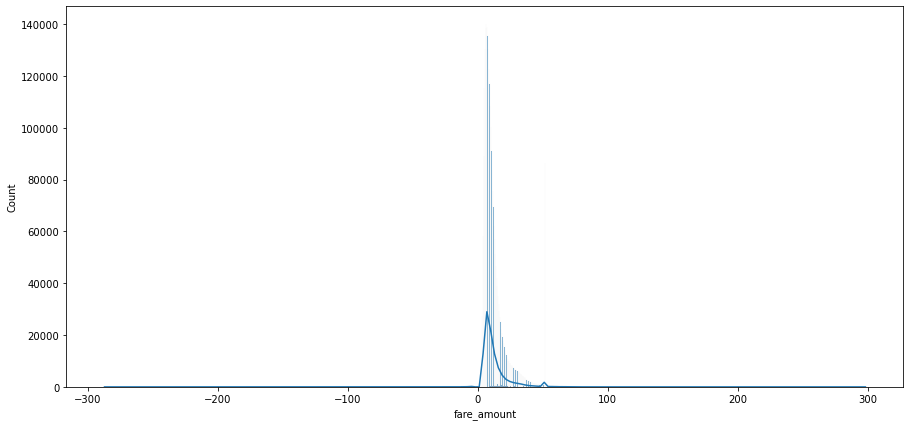

In [43]:
# plot histogram + pdf to understand fare amount distribution 
plt.figure(figsize=(15, 7))
sns.histplot(data=df, x='fare_amount', kde=True);

### Observation:
- fare_amount is dense within region 0-50 meaning most fares are between 0 and 50 dollars.

In [44]:
# check if fare amount is 0
print(f"Total fares with 0 as fare amount: {len(df.loc[df['fare_amount'] == 0].index)}")

# removing these points
df = df.drop(df.loc[df['fare_amount'] == 0].index)

print('Removed points where fare is equal to 0')

shape_after_removing_fare_amount_0 = df.shape[0]

Total fares with 0 as fare amount: 358
Removed points where fare is equal to 0


## 7.5. Analysis of Removed Outliers

In [45]:
df = df.reset_index(drop=True)

print(f'Points left after removing points where pick-ups and drop-offs were outisde NY: {shape_after_removing_pu_do_outside_ny}')
print(f'Points left after removing points where trip duration > 600 min: {shape_after_removing_trip_duration_outlier}')
print(f'Points left after removing points where trip speed > 47 m/hr: {shape_after_removing_trip_speed_outlier}')
print(f'Points left after removing points where trip distance > 25 miles: {shape_after_removing_trip_distance_outlier}')
print(f'Points left after removing points where total amount > $500: {shape_after_removing_total_amount_outlier}')
print(f'Points left after removing points where fare amount == $0: {shape_after_removing_fare_amount_0}')

print('-'*50)

print(f'Points when data was imported: {og_data_shape}')
print(f'Points left after removing all outliers: {shape_after_removing_fare_amount_0}')
print(f'% points left after removing all outliers: {np.round(shape_after_removing_fare_amount_0/og_data_shape*100, 2)}%')

Points left after removing points where pick-ups and drop-offs were outisde NY: 2947043
Points left after removing points where trip duration > 600 min: 2916149
Points left after removing points where trip speed > 47 m/hr: 2901261
Points left after removing points where trip distance > 25 miles: 2898547
Points left after removing points where total amount > $500: 2898546
Points left after removing points where fare amount == $0: 2898188
--------------------------------------------------
Points when data was imported: 3000000
Points left after removing all outliers: 2898188
% points left after removing all outliers: 96.61%


# 8. EDA with Cleaned Data
## 8.1. Zones with most/least pick-ups/drop-offs

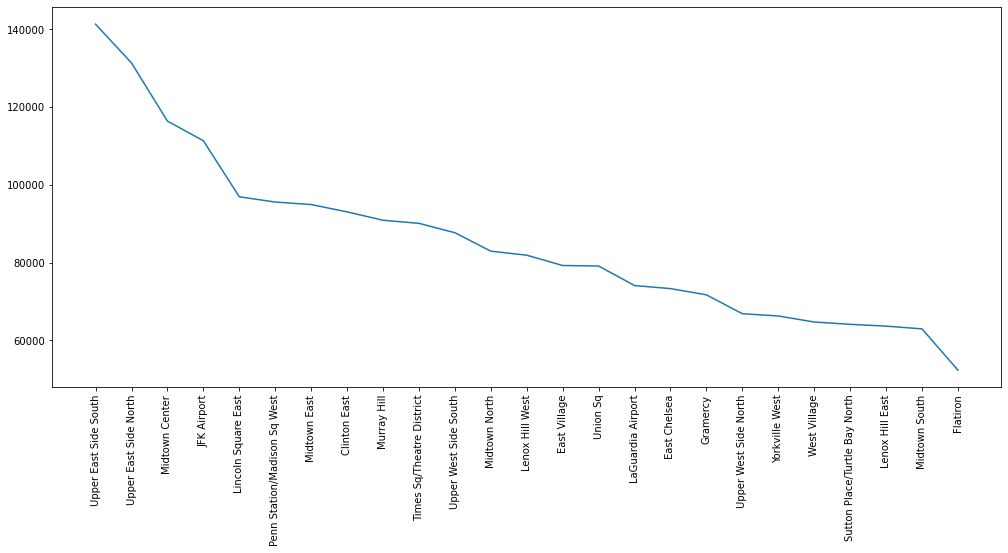

In [46]:
# find top-25 zones with least pick-ups
x = [i for i in range(len(df['pu_zone'].value_counts().head(25).index.tolist()))]
labels = df['pu_zone'].value_counts().head(25).index.tolist()

plt.figure(figsize=(17, 7))
sns.lineplot(data=df['pu_zone'].value_counts().head(25).values, markers=True, dashes=True)
plt.xticks(x, labels, rotation ='vertical');

In [47]:
dict(df['pu_zone'].value_counts().head(25))

{'Upper East Side South': 141327,
 'Upper East Side North': 131364,
 'Midtown Center': 116398,
 'JFK Airport': 111351,
 'Lincoln Square East': 96928,
 'Penn Station/Madison Sq West': 95576,
 'Midtown East': 94933,
 'Clinton East': 93044,
 'Murray Hill': 90893,
 'Times Sq/Theatre District': 90102,
 'Upper West Side South': 87689,
 'Midtown North': 82934,
 'Lenox Hill West': 81902,
 'East Village': 79249,
 'Union Sq': 79124,
 'LaGuardia Airport': 74089,
 'East Chelsea': 73309,
 'Gramercy': 71706,
 'Upper West Side North': 66849,
 'Yorkville West': 66269,
 'West Village': 64714,
 'Sutton Place/Turtle Bay North': 64121,
 'Lenox Hill East': 63654,
 'Midtown South': 62949,
 'Flatiron': 52336}

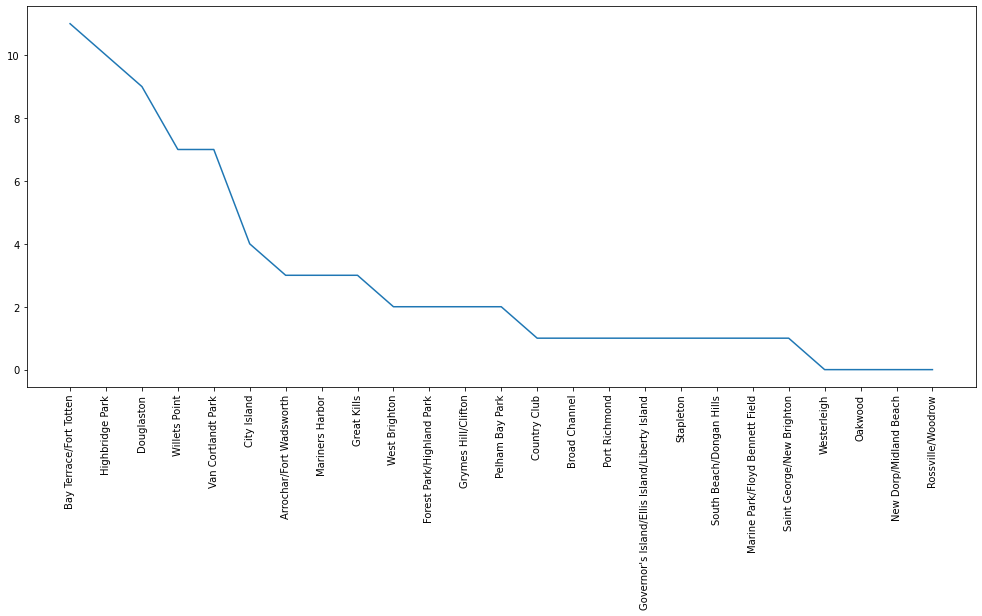

In [48]:
# find top-25 zones with least pick-ups
x = [i for i in range(len(df['pu_zone'].value_counts().tail(25).index.tolist()))]
labels = df['pu_zone'].value_counts().tail(25).index.tolist()

plt.figure(figsize=(17, 7))
sns.lineplot(data=df['pu_zone'].value_counts().tail(25).values, markers=True, dashes=True)
plt.xticks(x, labels, rotation ='vertical');

In [49]:
dict(df['pu_zone'].value_counts().tail(25))

{'Bay Terrace/Fort Totten': 11,
 'Highbridge Park': 10,
 'Douglaston': 9,
 'Willets Point': 7,
 'Van Cortlandt Park': 7,
 'City Island': 4,
 'Arrochar/Fort Wadsworth': 3,
 'Mariners Harbor': 3,
 'Great Kills': 3,
 'West Brighton': 2,
 'Forest Park/Highland Park': 2,
 'Grymes Hill/Clifton': 2,
 'Pelham Bay Park': 2,
 'Country Club': 1,
 'Broad Channel': 1,
 'Port Richmond': 1,
 "Governor's Island/Ellis Island/Liberty Island": 1,
 'Stapleton': 1,
 'South Beach/Dongan Hills': 1,
 'Marine Park/Floyd Bennett Field': 1,
 'Saint George/New Brighton': 1,
 'Westerleigh': 0,
 'Oakwood': 0,
 'New Dorp/Midland Beach': 0,
 'Rossville/Woodrow': 0}

## 8.2. Most frequently occuring pick-up and drop-off zones

In [50]:
pd.DataFrame(df[['pu_zone', 'do_zone']].value_counts()).head(25).reset_index().rename(columns={
    0:'count_of_trips'
})

,pu_zone,do_zone,count_of_trips
0,Upper East Side South,Upper East Side North,20458
1,Upper East Side North,Upper East Side South,17403
2,Upper East Side North,Upper East Side North,13501
3,Upper East Side South,Upper East Side South,12994
4,Upper East Side South,Midtown Center,8183
5,Midtown Center,Upper East Side South,7868
6,Lincoln Square East,Upper West Side South,7819
7,Upper West Side South,Upper West Side North,7795
8,Lenox Hill West,Upper East Side North,7672
9,Upper West Side South,Lincoln Square East,7651


## 8.3. Least frequently occuring pick-up and drop-off zones

In [51]:
pd.DataFrame(df[['pu_zone', 'do_zone']].value_counts()).tail(25).reset_index().rename(columns={
    0:'count_of_trips'
})

,pu_zone,do_zone,count_of_trips
0,Roosevelt Island,Kips Bay,1
1,Roosevelt Island,Jackson Heights,1
2,Roosevelt Island,Greenpoint,1
3,Roosevelt Island,Gramercy,1
4,Roosevelt Island,Flatiron,1
5,Roosevelt Island,East Village,1
6,Roosevelt Island,East Flatbush/Remsen Village,1
7,Roosevelt Island,Crown Heights North,1
8,Roosevelt Island,Central Park,1
9,Roosevelt Island,Canarsie,1


# 9. Data Preparation, more analysis and train-test split 
We'll create a regression model based on the following columns:
- trip_duration_minutes	
- trip_distance
- trip_speed

To predict:
- fare_amount

In [52]:
main_df = df[['trip_duration_minutes', 'trip_distance', 'trip_speed', 'fare_amount']]
main_df.head()

,trip_duration_minutes,trip_distance,trip_speed,fare_amount
0,14.0,2.30,9.857143,11.0
1,15.0,3.50,14.000000,12.5
2,9.0,1.23,8.200000,7.5
3,13.0,1.88,8.676923,10.5
4,10.0,2.90,17.400000,11.5


## 9.1. Check relationship input features and target column 
- relationship between trip_duration_minutes & fare_amount
- relationship between trip_distance & fare_amount
- relationship between trip_speed & fare_amount

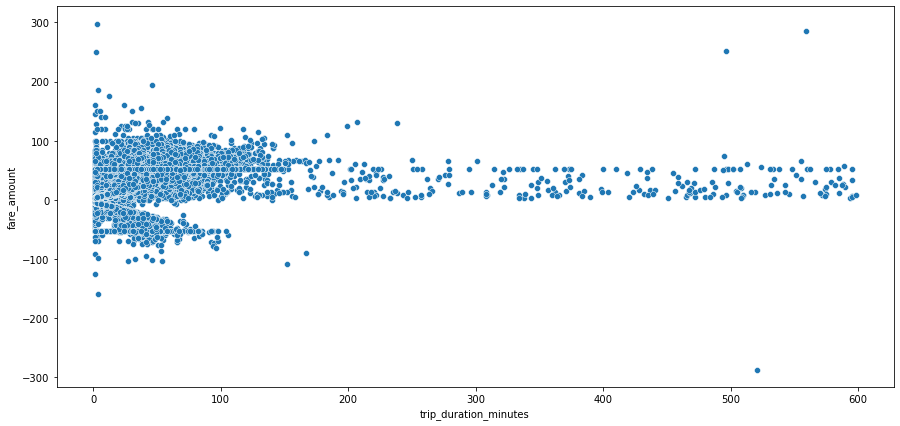

In [53]:
# relationship between fare_amount and total_amount
plt.figure(figsize=(15, 7))
sns.scatterplot(data=main_df, x='trip_duration_minutes', y='fare_amount');

### Observation:
- Scatter plot isn't very insightful

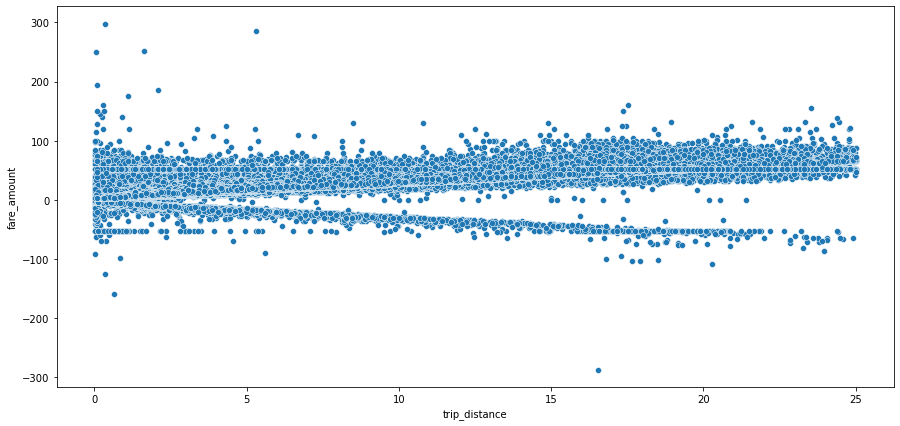

In [54]:
# relationship between fare_amount and total_amount
plt.figure(figsize=(15, 7))
sns.scatterplot(data=main_df, x='trip_distance', y='fare_amount');

### Observation:
- There is both positive are negative linear trend.

In [55]:
X = main_df.iloc[:, :-1]
y = main_df.iloc[:, -1]

In [56]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [57]:
# apply standard scaling
from sklearn.preprocessing import StandardScaler
std_scaler = StandardScaler()
X_train = std_scaler.fit_transform(X_train)
X_test = std_scaler.transform (X_test)

# 9. Applying ML Models
We'll apply the following regression models:
- Linear Regression
- Polynomial Regression
- Ridge Regression
- Lasso Regression

In [58]:
# linear regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error

lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_test = lr.predict(X_test)
y_pred_train = lr.predict(X_train)

mse_lin_reg_test = mean_squared_error(y_test, y_pred_test)
mse_lin_reg_train = mean_squared_error(y_train, y_pred_train)

mape_lin_reg_test = mean_absolute_percentage_error(y_test, y_pred_test)
mape_lin_reg_train = mean_absolute_percentage_error(y_train, y_pred_train)

print(f'MSE Linear Regression (test set): {mse_lin_reg_test}')
print(f'MSE Linear Regression (train set): {mse_lin_reg_train}')

print(f'MAPE Linear Regression (test set): {mape_lin_reg_test}')
print(f'MAPE Linear Regression (train set): {mape_lin_reg_train}')

MSE Linear Regression (test set): 9.674005821526258
MSE Linear Regression (train set): 9.516553782238226
MAPE Linear Regression (test set): 0.1051087408098317
MAPE Linear Regression (train set): 0.11419311256029945


### Observation:
- No massive difference in MSE and MAPE of train and test set
- Linear Regression is neither overfitting nor underfitting since MSE and MAPE error for both train and test is roughly similar

In [59]:
# polynomial regression
from sklearn.preprocessing import PolynomialFeatures

# degree 2
poly = PolynomialFeatures(degree=2,include_bias=True)
X_train_trans = poly.fit_transform(X_train)
X_test_trans = poly.transform(X_test)
lr.fit(X_train_trans, y_train)
y_pred_test = lr.predict(X_test_trans)
y_pred_train = lr.predict(X_train_trans)
mse_poly2_reg_test = mean_squared_error(y_test, y_pred_test)
mse_poly2_reg_train = mean_squared_error(y_train, y_pred_train)
mape_poly2_reg_test = mean_absolute_percentage_error(y_test, y_pred_test)
mape_poly2_reg_train = mean_absolute_percentage_error(y_train, y_pred_train)
print(f'MSE Polynomial Regression (degree 2) (test set): {mse_poly2_reg_test}')
print(f'MSE Polynomial Regression (degree 2) (train set): {mse_poly2_reg_train}')
print(f'MAPE Polynomial Regression (degree 2) (test set): {mape_poly2_reg_test}')
print(f'MAPE Polynomial Regression (degree 2) (train set): {mape_poly2_reg_train}')

print('-'*50)

# degree 3
poly = PolynomialFeatures(degree=3,include_bias=True)
X_train_trans = poly.fit_transform(X_train)
X_test_trans = poly.transform(X_test)
lr.fit(X_train_trans, y_train)
y_pred_test = lr.predict(X_test_trans)
y_pred_train = lr.predict(X_train_trans)
mse_poly3_reg_test = mean_squared_error(y_test, y_pred_test)
mse_poly3_reg_train = mean_squared_error(y_train, y_pred_train)
mape_poly3_reg_test = mean_absolute_percentage_error(y_test, y_pred_test)
mape_poly3_reg_train = mean_absolute_percentage_error(y_train, y_pred_train)
print(f'MSE Polynomial Regression (degree 3) (test set): {mse_poly3_reg_test}')
print(f'MSE Polynomial Regression (degree 3) (train set): {mse_poly3_reg_train}')
print(f'MAPE Polynomial Regression (degree 3) (test set): {mape_poly3_reg_test}')
print(f'MAPE Polynomial Regression (degree 3) (train set): {mape_poly3_reg_train}')

print('-'*50)

# degree 4
poly = PolynomialFeatures(degree=4,include_bias=True)
X_train_trans = poly.fit_transform(X_train)
X_test_trans = poly.transform(X_test)
lr.fit(X_train_trans, y_train)
y_pred_test = lr.predict(X_test_trans)
y_pred_train = lr.predict(X_train_trans)
mse_poly4_reg_test = mean_squared_error(y_test, y_pred_test)
mse_poly4_reg_train = mean_squared_error(y_train, y_pred_train)
mape_poly4_reg_test = mean_absolute_percentage_error(y_test, y_pred_test)
mape_poly4_reg_train = mean_absolute_percentage_error(y_train, y_pred_train)
print(f'MSE Polynomial Regression (degree 4) (test set): {mse_poly4_reg_test}')
print(f'MSE Polynomial Regression (degree 4) (train set): {mse_poly4_reg_train}')
print(f'MAPE Polynomial Regression (degree 4) (test set): {mape_poly4_reg_test}')
print(f'MAPE Polynomial Regression (degree 4) (train set): {mape_poly4_reg_train}')

MSE Polynomial Regression (degree 2) (test set): 8.319882522205623
MSE Polynomial Regression (degree 2) (train set): 8.405791860226602
MAPE Polynomial Regression (degree 2) (test set): 0.08030633911062997
MAPE Polynomial Regression (degree 2) (train set): 0.09110015557563367
--------------------------------------------------
MSE Polynomial Regression (degree 3) (test set): 8.032231565858082
MSE Polynomial Regression (degree 3) (train set): 8.099472792554604
MAPE Polynomial Regression (degree 3) (test set): 0.07041209880058909
MAPE Polynomial Regression (degree 3) (train set): 0.08355787834252844
--------------------------------------------------
MSE Polynomial Regression (degree 4) (test set): 7.990420050193231
MSE Polynomial Regression (degree 4) (train set): 8.069249929171916
MAPE Polynomial Regression (degree 4) (test set): 0.06988390762434317
MAPE Polynomial Regression (degree 4) (train set): 0.08265384375094256


### Observation:
- Polynomial Regression with degree = 4 gives the best MSE and MAPE on train and test set. 
- Polynomial Regression is neither overfitting nor underfitting since MSE and MAPE error for both train and test is roughly similar for all degrees

# 10. Model Performance

In [62]:
from prettytable import PrettyTable
model_performance = PrettyTable(["Model", "MSE Train Set", "MSE Test Set", "MAPE Train Set", "MAPE Test Set"])

# add rows
model_performance.add_row(["Linear Regression", mse_lin_reg_train, mse_lin_reg_test, mape_lin_reg_train, mape_lin_reg_test])
model_performance.add_row(["Polynomial Regression", mse_poly4_reg_train, mse_poly4_reg_test, mape_poly4_reg_train, mape_poly4_reg_test])

print(model_performance)

+-----------------------+-------------------+-------------------+---------------------+---------------------+
|         Model         |   MSE Train Set   |    MSE Test Set   |    MAPE Train Set   |    MAPE Test Set    |
+-----------------------+-------------------+-------------------+---------------------+---------------------+
|   Linear Regression   | 9.516553782238226 | 9.674005821526258 | 0.11419311256029945 |  0.1051087408098317 |
| Polynomial Regression | 8.069249929171916 | 7.990420050193231 | 0.08265384375094256 | 0.06988390762434317 |
+-----------------------+-------------------+-------------------+---------------------+---------------------+
